In [1]:
import numpy as np

from experiments.utils.SimpleComparison import SimpleComparison
from hdimvis.algorithms.spring_force_algos.chalmers96_algo.Chalmers96 import Chalmers96
from hdimvis.visualise_layouts_and_metrics.plot import show_layout,show_generation_metrics
from hdimvis.algorithms.stochastic_ntet_algo.SNeD import SNeD
from hdimvis.create_low_d_layout.LayoutCreation import LayoutCreation
from hdimvis.data_fetchers.DataFetcher import DataFetcher
from hdimvis.visualise_layouts_and_metrics.plot import show_layout
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold
from experiments.utils.get_kmeans_f1 import get_kmeans_f1
from experiments.utils.get_f1_for_best_k_with_knn import get_f1_for_best_k_with_knn
from experiments.utils.get_avg_classwise_f1 import get_avg_classwise_f1
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import f1_score
from pathlib import Path
from definitions import PROJECT_ROOT
import pickle
from scipy import stats
import matplotlib.pyplot as plt
from time import perf_counter
from  sklearn.manifold import SpectralEmbedding, MDS
from hdimvis.metrics.distance_measures.euclidian_and_manhattan import euclidean
import pandas as pd

In [2]:
output_dir= (Path(PROJECT_ROOT).joinpath(
    Path(f"experiments/knnd/out/"))).resolve().absolute()

path_to_pickle = (Path(output_dir).joinpath(Path(f"layouts.pickle"))).resolve()
with open(path_to_pickle, 'rb') as file:
    layouts = pickle.load(file)
# print(layouts)

In [1]:
# for name, dict in layouts.items():
#     print(name)
#     for type, ls in dict.items():
#         print(type)
#         for l in ls:
#             show_layout(l, use_labels=True)


In [5]:
output_dir= (Path(PROJECT_ROOT).joinpath(
    Path(f"experiments/knnd/out/"))).resolve().absolute()

path_to_pickle = (Path(output_dir).joinpath(Path(f"times.pickle"))).resolve()
with open(path_to_pickle, 'rb') as file:
    times = pickle.load(file)
print(times)

{'rna N3k': {'knnd': [85.31632380001247, 63.752671600086614, 63.74740770016797, 64.82735210005194, 65.18459600000642, 64.59016799996607, 63.802429100032896, 64.07501300005242, 64.28779600001872, 64.09899349999614, 64.80092409998178, 64.72249549999833, 63.79322290001437, 63.354148800019175, 64.30235060001723, 63.78219369985163, 63.682911900104955, 64.16301600006409, 64.04541250015609, 63.49404940009117, 63.91439009993337, 63.77847160003148, 63.64793949993327, 64.17900529992767, 65.1879226998426], 'no knnd': [83.69624890014529, 84.68989200005308, 83.98113120021299, 83.25401789997704, 83.20399270020425, 84.23498809989542, 83.98310529999435, 83.08164989994839, 83.85975219984539, 83.59804440010339, 83.56781659997068, 83.42386400001124, 84.08998779999092, 83.4031485999003, 83.5658438000828, 83.22416989994235, 84.42527849995531, 83.30991800012998, 83.43133950000629, 83.91075200005434, 83.80825729994103, 84.35294310003519, 82.8200451999437, 83.3459037002176, 82.78242840012535]}, 'coli20': {'kn

In [6]:
# rna N3k -  knnd first removed - outlier


names = ['rna N3k','coil20', 'globe', 'fashion mnist', 'mnist']


results_times = np.zeros((5,5))

for i, name in enumerate(names):
    if name == 'rna N3k':
        knnd = np.array(times[name]['knnd'])[1:]  # remove the outlier for rna n3k
    else:
        knnd = np.array(times[name]['knnd'])

    no_knnd = np.array(times[name]['no knnd'])

    results_times[i,0] = np.mean(knnd).round(2)
    results_times[i,1] = np.std(knnd).round(2)
    results_times[i,2] = np.mean(no_knnd).round(2)
    results_times[i,3] = np.std(no_knnd).round(2)

    tstat, pvalue = stats.ttest_ind(no_knnd, knnd, equal_var=False, alternative='greater')
    results_times[i,4] = np.format_float_scientific(pvalue, precision=2,min_digits=2)

    # print(f"{name}:"
    #   f"Mean kNNd: {np.mean(knnd).round(2)}, SD: {np.std(knnd).round(2)} \n"
    #   f"Mean no knnd {np.mean(no_knnd).round(2)}, SD: {np.std(no_knnd).round(2)} \n")
    # # tstat, pvalue = stats.ttest_ind(knnd, no_knnd[:,1], equal_var=False, alternative='greater')
    # # print(pvalue)
    # print('#'*20)

# print(results_times)



NameError: name 'times' is not defined

fashion mnist
knnd


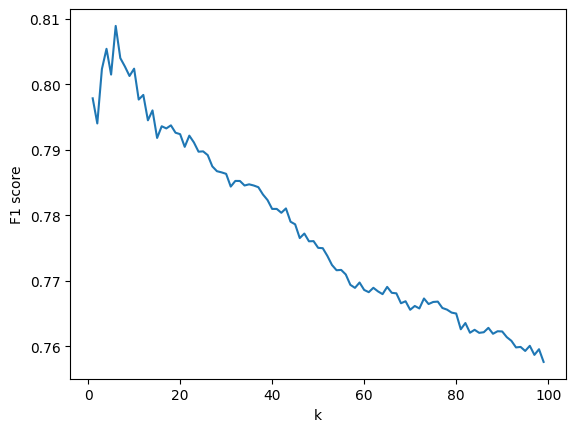

no knnd


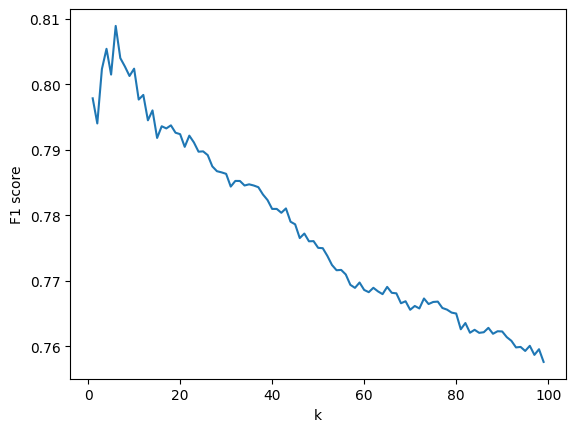

mnist
knnd


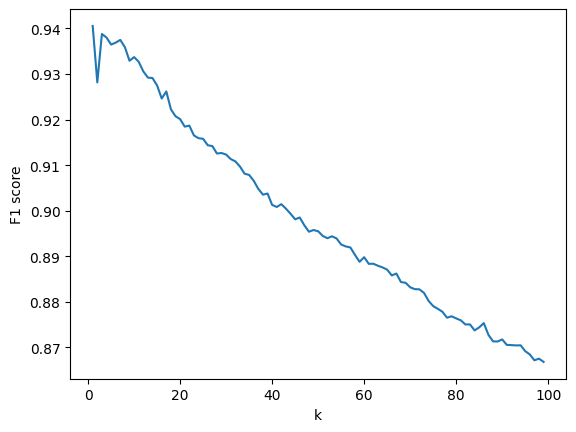

no knnd


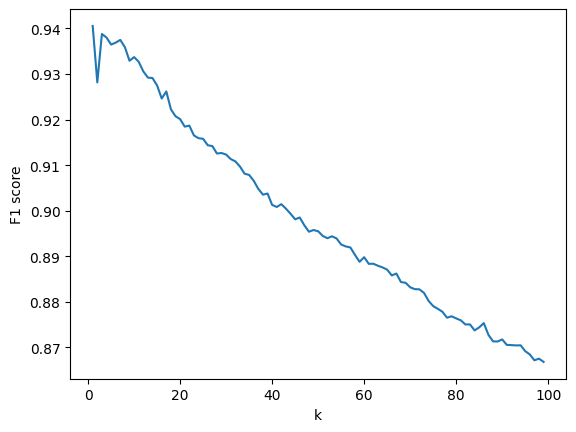

In [8]:
# see what good bounds for k might be for knn classifier
for dataset_name, version_dict in layouts.items():
    if dataset_name == "fashion mnist" or dataset_name == "mnist":
        print(dataset_name)
        for j, version in enumerate(['knnd', 'no knnd']):
            print(version)
            layout = version_dict[version][0]
            get_f1_for_best_k_with_knn(lower_bound=1, upper_bound=100,
                                         cross_validation_folds=10,
                                         data=layout.data,
                                         labels=layout.labels,
                                       show_averages=True)



In [14]:
names = ['rna N3k','coli20', 'globe', 'fashion mnist', 'mnist']
results_arr = np.zeros((5,2,20,4)) # 5 datasets, 2 version - knnd and not, 20 repeats, 4 stats

for dataset_name, version_dict in layouts.items():
    print(dataset_name)
    print(names.index(dataset_name))
    for j, version in enumerate(['knnd', 'no knnd']):
        # for i,layout in enumerate(version_dict[version]):
            layout = version_dict[version][0]
            stress = layout.get_final_stress()
            kmeans_f1 = get_kmeans_f1(layout.get_final_positions(), layout.labels)
            f1_for_best_k_with_knn =  get_f1_for_best_k_with_knn(lower_bound=1, upper_bound=3,
                                                                 cross_validation_folds=10,
                                                                 data=layout.data,
                                                                 labels=layout.labels)

            results_arr[names.index(dataset_name),j,0,0] = stress
            results_arr[names.index(dataset_name),j,0,1] = kmeans_f1
            results_arr[names.index(dataset_name),j,0,2],results_arr[names.index(dataset_name),j,0,3] = f1_for_best_k_with_knn

print(results_arr)
output_dir= (Path(PROJECT_ROOT).joinpath(
    Path(f"experiments/knnd/out/"))).resolve().absolute()

path_to_pickle_lay = (Path(output_dir).joinpath(Path(f"results_arr.pickle"))).resolve()
with open(path_to_pickle_lay, 'wb') as pickle_out:
    pickle.dump(layouts, pickle_out)




rna N3k
0


C:\Users\Owner\.virtualenvs\2095736w-0SnFieZ0\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Owner\.virtualenvs\2095736w-0SnFieZ0\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Owner\.virtualenvs\2095736w-0SnFieZ0\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Owner\.virtualenvs\2095736w-0SnFieZ0\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress t


 Computing vectorised euclidean stress 



C:\Users\Owner\.virtualenvs\2095736w-0SnFieZ0\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Owner\.virtualenvs\2095736w-0SnFieZ0\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Owner\.virtualenvs\2095736w-0SnFieZ0\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Owner\.virtualenvs\2095736w-0SnFieZ0\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress t

coli20
1

 Computing vectorised euclidean stress 



C:\Users\Owner\.virtualenvs\2095736w-0SnFieZ0\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Owner\.virtualenvs\2095736w-0SnFieZ0\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Owner\.virtualenvs\2095736w-0SnFieZ0\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Owner\.virtualenvs\2095736w-0SnFieZ0\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress t


 Computing vectorised euclidean stress 



C:\Users\Owner\.virtualenvs\2095736w-0SnFieZ0\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Owner\.virtualenvs\2095736w-0SnFieZ0\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Owner\.virtualenvs\2095736w-0SnFieZ0\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Owner\.virtualenvs\2095736w-0SnFieZ0\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress t

globe
2

 Computing vectorised euclidean stress 



C:\Users\Owner\.virtualenvs\2095736w-0SnFieZ0\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Owner\.virtualenvs\2095736w-0SnFieZ0\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Owner\.virtualenvs\2095736w-0SnFieZ0\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Owner\.virtualenvs\2095736w-0SnFieZ0\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress t


 Computing vectorised euclidean stress 



C:\Users\Owner\.virtualenvs\2095736w-0SnFieZ0\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Owner\.virtualenvs\2095736w-0SnFieZ0\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Owner\.virtualenvs\2095736w-0SnFieZ0\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Owner\.virtualenvs\2095736w-0SnFieZ0\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress t

fashion mnist
3

Not enough memory to allocate for a numpy array for stress calculation. 
Stress will be calculated with a Python loop

 Computing un-vectorised euclidean stress 



C:\Users\Owner\.virtualenvs\2095736w-0SnFieZ0\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Owner\.virtualenvs\2095736w-0SnFieZ0\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Owner\.virtualenvs\2095736w-0SnFieZ0\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Owner\.virtualenvs\2095736w-0SnFieZ0\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress t


Not enough memory to allocate for a numpy array for stress calculation. 
Stress will be calculated with a Python loop

 Computing un-vectorised euclidean stress 



C:\Users\Owner\.virtualenvs\2095736w-0SnFieZ0\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Owner\.virtualenvs\2095736w-0SnFieZ0\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Owner\.virtualenvs\2095736w-0SnFieZ0\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Owner\.virtualenvs\2095736w-0SnFieZ0\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress t

mnist
4

Not enough memory to allocate for a numpy array for stress calculation. 
Stress will be calculated with a Python loop

 Computing un-vectorised euclidean stress 



C:\Users\Owner\.virtualenvs\2095736w-0SnFieZ0\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Owner\.virtualenvs\2095736w-0SnFieZ0\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Owner\.virtualenvs\2095736w-0SnFieZ0\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Owner\.virtualenvs\2095736w-0SnFieZ0\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress t


Not enough memory to allocate for a numpy array for stress calculation. 
Stress will be calculated with a Python loop

 Computing un-vectorised euclidean stress 



C:\Users\Owner\.virtualenvs\2095736w-0SnFieZ0\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Owner\.virtualenvs\2095736w-0SnFieZ0\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Owner\.virtualenvs\2095736w-0SnFieZ0\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Owner\.virtualenvs\2095736w-0SnFieZ0\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress t

rna N3k
0


C:\Users\Owner\.virtualenvs\2095736w-0SnFieZ0\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Owner\.virtualenvs\2095736w-0SnFieZ0\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Owner\.virtualenvs\2095736w-0SnFieZ0\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Owner\.virtualenvs\2095736w-0SnFieZ0\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress t

coli20
1


C:\Users\Owner\.virtualenvs\2095736w-0SnFieZ0\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Owner\.virtualenvs\2095736w-0SnFieZ0\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Owner\.virtualenvs\2095736w-0SnFieZ0\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Owner\.virtualenvs\2095736w-0SnFieZ0\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress t

globe
2


C:\Users\Owner\.virtualenvs\2095736w-0SnFieZ0\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Owner\.virtualenvs\2095736w-0SnFieZ0\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Owner\.virtualenvs\2095736w-0SnFieZ0\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Owner\.virtualenvs\2095736w-0SnFieZ0\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress t

fashion mnist
3


C:\Users\Owner\.virtualenvs\2095736w-0SnFieZ0\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Owner\.virtualenvs\2095736w-0SnFieZ0\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Owner\.virtualenvs\2095736w-0SnFieZ0\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Owner\.virtualenvs\2095736w-0SnFieZ0\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress t

In [ ]:
# see the means
# for i in range(3):
#     means_arr = np.mean(results_arr[:,:,:,i], axis=2)


# _, pvalues_stress = stats.ttest_ind(results_arr[:,0,:,0], results_arr[:,1,:,0],
#                                     axis=1,equal_var=False,alternative='two sided' )
# _, pvalues_kmeans = stats.ttest_ind(results_arr[:,0,:,1], results_arr[:,1,:,1],
#                                     axis=1,equal_var=False,alternative='two sided' )
# _, pvalues_knn = stats.ttest_ind(results_arr[:,0,:,2], results_arr[:,1,:,2],
#                                     axis=1,equal_var=False,alternative='two sided' )
